# Analysis

This notebook analyzes predicted results from the VM and attempt to do some other shit

In [1]:
import os
import pickle
from pytorch_pretrained_bert import BertTokenizer
import numpy as np
from rouge import Rouge 
import util
from tqdm import tqdm
import matplotlib.pyplot as plt
from multiprocessing import Pool

In [2]:
machine = 'Google'

In [3]:
with open(os.path.join('saved_models', machine, 'test', 'default-01-dev', 'X_batch.pk'), 'rb') as f:
    X_batch = pickle.load(f)
with open(os.path.join('saved_models', machine, 'test', 'default-01-dev', 'logits_batch.pk'), 'rb') as f:
    logits_batch = pickle.load(f)
with open(os.path.join('saved_models', machine, 'test', 'default-01-dev', 'gold_sums.pk'), 'rb') as f:
    gold_sums = pickle.load(f)
PROCESSED_DATA = os.path.join('data', 'data.pk')
with open(PROCESSED_DATA, 'rb') as f:
    data = pickle.load(f)

## LEAD-3 Basline

Here, we recover the source document by untokenizing from Bert and select the top 3 sentences as our "summary" and observe the results

In [4]:
def to_normal_sent(lst_of_words):
    return util.remove_bert_tokens(' '.join(lst_of_words))

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
rouge = Rouge()

In [7]:
X = data['test']['X']
gold_sums = data['test']['gold']
recovered_X = [tokenizer.convert_ids_to_tokens(x) for x in X]

In [11]:
def lead_k(x, k=3, thresh=10):
    start, look, i = 0, 0, 0
    while i < k:
        if '[SEP]' not in x[look:]:
            start, look = 0, 100
            break;
        look = x.index('[SEP]', look)
        look += 1
        if look - start > thresh or i > 0:
            i += 1
        else:
            start = look
    look = min(look, 100)
    return util.remove_bert_tokens(' '.join(x[start:look]))

In [12]:
lead_3_sums = [lead_k(x, thresh=10) for x in recovered_X]

In [13]:
print('lead-3 summaries avg length: {}'.format(np.mean([len(s) for s in lead_3_sums])))
print('gold summaries avg length: {}'.format(np.mean([len(sent) for sent in gold_sums])))

lead-3 summaries avg length: 386.4782413638403
gold summaries avg length: 296.30468499647503


In [14]:
valid_ids = [i for i in range(len(lead_3_sums)) \
        if len(lead_3_sums[i]) > 0 and lead_3_sums[i][0] != '.']
lead_3_sums_filtered = [lead_3_sums[i] for i in valid_ids]
gold_sums_filtered = [gold_sums[i] for i in valid_ids]
rouge.get_scores(lead_3_sums_filtered, gold_sums_filtered, avg=True)

{'rouge-1': {'f': 0.3821599974324617,
  'p': 0.34986469518907654,
  'r': 0.44766975429590955},
 'rouge-2': {'f': 0.15456418398646685,
  'p': 0.138567864621563,
  'r': 0.19059111347871827},
 'rouge-l': {'f': 0.3238989896185224,
  'p': 0.3155679251844099,
  'r': 0.40387085568306264}}

## Token tagging

Here we explore some token taggnig ideas.

In [21]:
def range_dist(tup1, tup2):
    """
    This function calculates the distance between 2 ranges.
    """
    start1, end1 = min(tup1), max(tup1)
    start2, end2 = min(tup2), max(tup2)
    if start1 < start2 < end1 or start1 < end2 < end1: # overlap
        return 0
    return min(abs(end1 - start2), abs(end2 - start1))

def tag(doc, tgt):
    """
    doc: a list of src tokens
    tgt: a list of tgt tokens that we will look for in the doc
    
    returns:
    decode_label: a list of size tgt (or less) denoting the positions of the tokens at each summ step
    """
    if len(tgt) == 0:
        print('zero sized tgt')
        return None

    decode_label = []
    l, r, last_range = 0, 0, (0, 0) # last step is the index into the src where we chose last
    while r < len(tgt):
        old_idxs = []
        idxs = [(i,i+1) for i, token in enumerate(doc) if token == tgt[r]]
        while len(idxs) > 0: # found a match
            r += 1
            old_idxs, idxs = idxs, []
            for start, end in old_idxs:
                if end < len(doc) and r < len(tgt) and doc[end] == tgt[r]:
                    idxs.append((start, end + 1))
        idx_to_look = old_idxs if len(idxs) == 0 else idxs
        if len(idx_to_look) == 0:
            r += 1
        else:
            best_i = min(range(len(idx_to_look)), key=lambda i: range_dist(last_range, idx_to_look[i]))
            last_range = idx_to_look[best_i]
            decode_label.extend(list(range(last_range[0], last_range[1])))
    decode_label2 = []
    l, r, last_range = 0, 0, (0, 0) # last step is the index into the src where we chose last
    while r < len(tgt):
        old_idxs = []
        idxs = [(i,i+1) for i, token in enumerate(doc) if token == tgt[r]]
        while len(idxs) > 0: # found a match
            r += 1
            old_idxs, idxs = idxs, []
            for start, end in old_idxs:
                if end < len(doc) and r < len(tgt) and doc[end] == tgt[r]:
                    idxs.append((start, end + 1))
        idx_to_look = old_idxs if len(idxs) == 0 else idxs
        if len(idx_to_look) == 0:
            r += 1
        else:
            best_i = 0
            last_range = idx_to_look[best_i]
            decode_label2.extend(list(range(last_range[0], last_range[1])))
    return decode_label, decode_label2

In [242]:
i = 3

In [243]:
a, b = tag(recovered_X[i], gold_sums[i].split(' '))

In [244]:
print('\t'.join([str(elem) for elem in a]))

56	57	58	62	67	68	69	146	47	46	39	82	80	81	108	83	84	85	87	89	90	91	298	299	462	463	21	22	476	189	190	179	152	153	154	155	157	437	438	490	224	433	424


In [245]:
print('\t'.join([str(elem) for elem in b]))

56	57	58	62	67	68	69	146	47	46	39	82	80	81	108	83	84	85	9	89	90	91	298	299	18	19	21	22	476	189	190	39	152	153	154	155	71	437	438	62	167	433	39


In [249]:
to_normal_sent(recovered_X[i])

"canadian security forces have thwarted an al - qaeda - backed terrorist plot to derail a new york city - bound passenger train as it crossed the niagara river , just a few miles from niagara falls . the royal canadian mounted police yesterday arrested chiheb esseghaier , 30 , of montreal , and raed jaser , 35 , of toronto . authorities allege the pair took orders and received guidance from al - qaeda operatives in iran . officials reportedly watched the men for more than a year and say the plot never got past the planning stages . canadian counter - terrorism investigators say the public was never in danger , the the men would have carried out the attack if they had not been stopped . police were later seen raiding jaser ' s house in northern toronto , carrying away material which could be used as evidence in the suspects ' prosecution . scroll down for video . raid : police were pictured at a house in toronto yesterday in connection with a plot to blow up a train . operation : the al

In [250]:
gold_sums[i]

"chiheb esseghaier , 30 , and raed jaser , 35 , were arrested yesterday . suspected received orders and got guidance from al qaeda leader in iran . planned to target new york - bound trains in toronto . jaser ' s house in toronto raided by police and evidence removed ."

## Thresholds

Here we change experiment with the thresholds and find a threshold that closely match the mean length of the gold summaries

In [4]:
def to_normal_sent(lst_of_words):
    return util.remove_bert_tokens(' '.join(lst_of_words))

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
rouge = Rouge()

In [7]:
X = data['dev']['X']
gold_sums = data['dev']['gold']
recovered_X = [tokenizer.convert_ids_to_tokens(x) for x in X]

In [39]:
threshold = -2.5

In [40]:
all_preds = []
with tqdm(total=sum(X.size(0) for X in X_batch)) as progress_bar:
    for X, logits in zip(X_batch, logits_batch):
        preds = util.tag_to_sents(X, logits, threshold=threshold, topk=0, max_len=120)
        all_preds.extend(preds)
        progress_bar.update(X.size(0))

100%|██████████| 15603/15603 [00:01<00:00, 10939.28it/s]


In [41]:
np.mean([len(sent) for sent in all_preds])

541.2703967185797

In [42]:
np.mean([len(sent) for sent in gold_sums])

296.77952957764535

In [43]:
# valid_ids = [i for i in range(len(all_preds)) \
#         if len(all_preds[i]) > 0 and all_preds[i][0] != '.']
# pred = [all_preds[i] for i in valid_ids]
# ref = [gold_sums[i] for i in valid_ids]
# rouge = Rouge()
# results = rouge.get_scores(pred, ref, avg=True)

In [44]:
# results

In [45]:
all_preds[79]

"a kansas jury deliberate 37 minutes before convicting an anti - abortion activist of first - degree murder in the shooting of an abortion provider . the jury found scott roeder , 51 , guilty of gunning down dr . george tiller , who operated a clinic in wichita where late - term abortions were performed . roeder , 51 , faces life in prison when he is sentenced on march 9 . tiller ' s family said the jury reached a ` ` just ' ' verdict . ` ` for his a ' ' family . arors he had shot tiller in"

In [46]:
gold_sums[79]

"scott roeder convicted of first - degree murder . jury reaches verdict after about 40 minutes of deliberation . roeder testified he does not regret killing dr . george tiller . tiller ran a women ' s clinic where he performed abortions in wichita , kansas ."

In [48]:
util.remove_bert_tokens(' '.join(recovered_X[79]))

"- lrb - cnn - rrb - - - a kansas jury deliberated just 37 minutes before convicting an anti - abortion activist of first - degree murder in the fatal shooting of an abortion provider . the jury found scott roeder , 51 , guilty of gunning down dr . george tiller , who operated a clinic in wichita where late - term abortions were performed . roeder , 51 , faces life in prison when he is sentenced on march 9 . tiller ' s family said the jury reached a ` ` just ' ' verdict . ` ` at this time we hope that george can be remembered for his legacy of service to women , the help he provided for those who needed it and the love and happiness he provided us as a husband , father and grandfather , ' ' the family said in a written statement . a day earlier , roeder told jurors he had shot tiller in the foyer of reformation lutheran church as sunday services began . testifying as his only defense witness , he said he believed he had to kill tiller to save lives . he said he had no regrets . ` ` the

In [30]:
threshold = -2.0

In [31]:
all_preds = []
with tqdm(total=sum(X.size(0) for X in X_batch)) as progress_bar:
    for X, logits in zip(X_batch, logits_batch):
        preds = util.tag_to_sents(X, logits, threshold=threshold, topk=0)
        all_preds.extend(preds)
        progress_bar.update(X.size(0))

100%|██████████| 15603/15603 [00:01<00:00, 12702.92it/s]


In [32]:
np.mean([len(sent) for sent in all_preds])

466.65192591168363

In [33]:
np.mean([len(sent) for sent in gold_sums])

296.77952957764535

In [34]:
valid_ids = [i for i in range(len(all_preds)) \
        if len(all_preds[i]) > 0 and all_preds[i][0] != '.']
pred = [all_preds[i] for i in valid_ids]
ref = [gold_sums[i] for i in valid_ids]
rouge = Rouge()
results = rouge.get_scores(pred, ref, avg=True)

In [35]:
results

{'rouge-1': {'f': 0.4496899122869815,
  'p': 0.40063215739225777,
  'r': 0.53974616094343},
 'rouge-2': {'f': 0.18567803647011386,
  'p': 0.1559749627169229,
  'r': 0.24639956474697608},
 'rouge-l': {'f': 0.39346003244870503,
  'p': 0.3737589285073313,
  'r': 0.5040702011647212}}

In [58]:
threshold = -1.7

In [59]:
all_preds = []
with tqdm(total=sum(X.size(0) for X in X_batch)) as progress_bar:
    for X, logits in zip(X_batch, logits_batch):
        preds = util.tag_to_sents(X, logits, threshold=threshold, topk=0)
        all_preds.extend(preds)
        progress_bar.update(X.size(0))

100%|██████████| 15603/15603 [00:01<00:00, 13316.56it/s]


In [60]:
np.mean([len(sent) for sent in all_preds])

427.02268794462606

In [61]:
np.mean([len(sent) for sent in gold_sums])

296.77952957764535

In [62]:
valid_ids = [i for i in range(len(all_preds)) \
        if len(all_preds[i]) > 0 and all_preds[i][0] != '.']
pred = [all_preds[i] for i in valid_ids]
ref = [gold_sums[i] for i in valid_ids]
rouge = Rouge()
results = rouge.get_scores(pred, ref, avg=True)

In [63]:
results

{'rouge-1': {'f': 0.45086845580397156,
  'p': 0.4185434317870088,
  'r': 0.5168249621833642},
 'rouge-2': {'f': 0.1829220373807808,
  'p': 0.15901565244835605,
  'r': 0.23124963445101152},
 'rouge-l': {'f': 0.3999566875681731,
  'p': 0.39202406330937495,
  'r': 0.4843581547513276}}

In [42]:
threshold = -1.6

In [43]:
all_preds = []
with tqdm(total=sum(X.size(0) for X in X_batch)) as progress_bar:
    for X, logits in zip(X_batch, logits_batch):
        preds = util.tag_to_sents(X, logits, threshold=threshold, topk=0)
        all_preds.extend(preds)
        progress_bar.update(X.size(0))

100%|██████████| 15603/15603 [00:01<00:00, 14216.06it/s]


In [44]:
np.mean([len(sent) for sent in all_preds])

363.1303595462411

In [45]:
np.mean([len(sent) for sent in gold_sums])

296.77952957764535

In [46]:
valid_ids = [i for i in range(len(all_preds)) \
        if len(all_preds[i]) > 0 and all_preds[i][0] != '.']
pred = [all_preds[i] for i in valid_ids]
ref = [gold_sums[i] for i in valid_ids]
rouge = Rouge()
results = rouge.get_scores(pred, ref, avg=True)

In [47]:
results

{'rouge-1': {'f': 0.44244367142312696,
  'p': 0.44210512732771956,
  'r': 0.47261537854014235},
 'rouge-2': {'f': 0.17633962658940505,
  'p': 0.16432195309989306,
  'r': 0.2057540133100572},
 'rouge-l': {'f': 0.39573376477645517,
  'p': 0.4153099454535798,
  'r': 0.44399267718797564}}

In [48]:
pred[4]

"the obama administration launch the federal healthcare site was not ready to go live confidential report cnn . . the caution main contractor cgi warned of a of open risks and issues for healthcare . gov web site project . medicaid chief marilyn tavenner it website she not fore problems . ` ` tested website with ' . in ' ' . ' s . risks open says . is . c ."

In [49]:
ref[4]

"a confidential report obtained by cnn details warning that site was n ' t ready to go live . the main contractor warned of a number of open risks and issues for healthcare . gov . agency overseeing website said it addressed problems , was told project on track ."

In [387]:
threshold = 0.5

In [388]:
all_preds = []
with tqdm(total=sum(X.size(0) for X in X_batch)) as progress_bar:
    for X, logits in zip(X_batch, logits_batch):
        preds = util.tag_to_sents(X, logits, threshold=threshold, topk=0)
        all_preds.extend(preds)
        progress_bar.update(X.size(0))

100%|██████████| 15603/15603 [00:00<00:00, 33320.87it/s]


In [389]:
np.mean([len(sent) for sent in all_preds])

11.073383323719797

In [390]:
np.mean([len(sent) for sent in gold_sums])

296.77952957764535

In [475]:
choice = 21

In [476]:
# choice = 107

In [477]:
all_preds[choice]

'drought iguanas . low rainfall in unusually hot season has led to series of droughts in parts of el salvador , guatemala , honduras and nicaragua crops food prices . government expert in nicaragua has recommended keeping and eating iguanas as a way of providing food . worst draught in 32 years threatens to cause food crisis expert nicaragua people keeping eating iguanas . lizards 24 more protein chicken . huntinggua is food . iguana meat . . crops destroyed by poor rainfall .'

In [479]:
gold_sums[choice]

'low rainfall and hot weather has led to series of droughts across region . government expert in nicaragua has advised keeping and eating iguanas . he said the lizard could not only provide food but could also provide income .'

In [407]:
threshold = -1.7

In [408]:
all_preds = []
with tqdm(total=sum(X.size(0) for X in X_batch)) as progress_bar:
    for X, logits in zip(X_batch, logits_batch):
        preds = util.tag_to_sents(X, logits, threshold=threshold, topk=0, max_len=500)
        all_preds.extend(preds)
        progress_bar.update(X.size(0))

100%|██████████| 15603/15603 [00:01<00:00, 11628.58it/s]


In [384]:
np.mean([len(sent) for sent in all_preds])

504.03057104403

In [385]:
np.mean([len(sent) for sent in gold_sums])

296.77952957764535

In [386]:
all_preds[choice]

"the . but sims devices . a cambridge computer science experts believes the small microchips ' days are and should be phones in the online accounts . dr markus kuhn from the university of cambridge said the sim could have been replaced long ago . he believes alternatives include typing in a user identifier and password directly into a phone . sim could with id and password into the phone is to access wifi of cambridge . or qr codes 3d are more alternative for smartphones with cameras app can . the to . . ' believes sims with passwords software it . they ."

In [331]:
gold_sums[choice]

'dr markus kuhn said the sim could have been replaced a long time ago . he believes one alternative could be typing in a user identifier and password directly into a phone - like we do with wi - fi networks . or details could be encoded in qr codes photographed by a phone camera . the university of cambridge lecturer also believes the time is right to switch because of recent advances in cryptographic techniques .'

In [478]:
util.remove_bert_tokens(' '.join(recovered_X[choice]))

"by . james rush for mailonline . as the worst drought in 32 years threatens to cause a food crisis across central america , people living in nicaragua have been advised to consider farming and eating iguanas . low rainfall in an unusually hot season has led to a series of droughts in parts of el salvador , guatemala , honduras and nicaragua , damaging crops and pushing up food prices . now , a government expert in nicaragua has recommended keeping and eating iguanas as a way of providing food , as well as an income . as the worst draught in 32 years threatens to cause a food crisis across central america , a government expert in nicaragua has recommended people keeping and eating iguanas . land management expert guillermo membreno told state - run online newspaper la voz del sandinismo , as translated by the guardian : ` breeding iguanas brings two benefits . not only does it supply dietary protein , it also offers a commercial use for the animals . ' he said the tropical lizards cont

Insights:

1. Lower threshold results in longer sentences, and will trivially improve ROUGE scores. Thus we pick a threshold that match the predicted average length of the summaries with true average length of the summaries. 

### Threshold plots

Simple thresholds is not gonna cut it. Must use plots

In [25]:
def evaluate_threshold(threshold):
    all_preds = []
    for X, logits in zip(X_batch, logits_batch):
        preds = util.tag_to_sents(X, logits, threshold=threshold, topk=0, max_len=120)
        all_preds.extend(preds)
    valid_ids = [i for i in range(len(all_preds)) \
            if len(all_preds[i]) > 3]
    pred = [all_preds[i] for i in valid_ids]
    ref = [gold_sums[i] for i in valid_ids]
    rouge = Rouge()
    results = rouge.get_scores(pred, ref, avg=True)
    results['avg_len'] = np.mean([len(sent) for sent in pred])
    return (threshold, results)

In [256]:
pool = Pool(7)

In [7]:
search_range = np.linspace(-2.5, 1, 50)

In [258]:
result = pool.map(evaluate_threshold, search_range)

In [260]:
with open(os.path.join('saved_models', machine, 'test', 'default-01-dev', 'threshold_eval.pk'), 'wb') as f:
    pickle.dump(result, f)

In [5]:
with open(os.path.join('saved_models', machine, 'test', 'default-01-dev', 'threshold_eval.pk'), 'rb') as f:
    result = pickle.load(f)

In [26]:
result_merged = {list(elem.keys())[0]: list(elem.values())[0] for elem in result}

In [28]:
rouge1_p = np.array([result_merged[i]['rouge-1']['p'] for i in search_range])
rouge1_r = np.array([result_merged[i]['rouge-1']['r'] for i in search_range])
rouge1_f = np.array([result_merged[i]['rouge-1']['f'] for i in search_range])

rouge2_p = np.array([result_merged[i]['rouge-2']['p'] for i in search_range])
rouge2_r = np.array([result_merged[i]['rouge-2']['r'] for i in search_range])
rouge2_f = np.array([result_merged[i]['rouge-2']['f'] for i in search_range])

rougeL_p = np.array([result_merged[i]['rouge-l']['p'] for i in search_range])
rougeL_r = np.array([result_merged[i]['rouge-l']['r'] for i in search_range])
rougeL_f = np.array([result_merged[i]['rouge-l']['f'] for i in search_range])

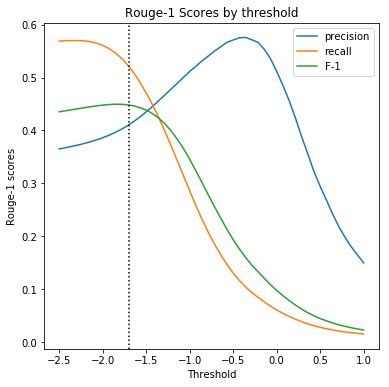

In [75]:
plt.figure(figsize=(6, 6))
plt.plot(search_range, rouge1_p)
plt.plot(search_range, rouge1_r)
plt.plot(search_range, rouge1_f)
plt.axvline(x=-1.7, color='black', ls=':')
plt.legend(['precision', 'recall', 'F-1'], loc='upper right')
plt.xlabel('Threshold')
plt.ylabel('Rouge-1 scores')
plt.title('Rouge-1 Scores by threshold')
plt.savefig(os.path.join('paper', 'plots', 'rouge-1.png'))

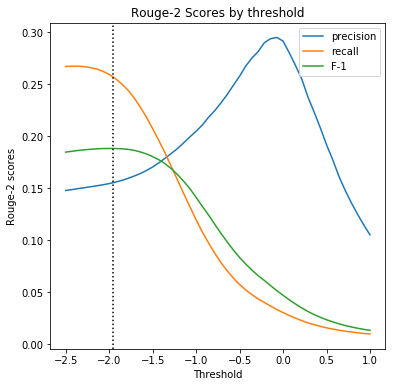

In [59]:
plt.figure(figsize=(6, 6))
plt.plot(search_range, rouge2_p)
plt.plot(search_range, rouge2_r)
plt.plot(search_range, rouge2_f)
plt.axvline(x=-1.95, color='black', ls=':')
plt.legend(['precision', 'recall', 'F-1'], loc='upper right')
plt.xlabel('Threshold')
plt.ylabel('Rouge-2 scores')
plt.title('Rouge-2 Scores by threshold')
plt.savefig(os.path.join('paper', 'plots', 'rouge-2.png'))

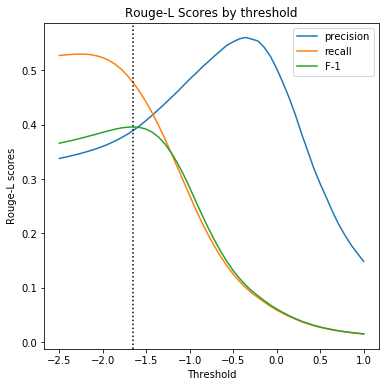

In [71]:
plt.figure(figsize=(6, 6))
plt.plot(search_range, rougeL_p)
plt.plot(search_range, rougeL_r)
plt.plot(search_range, rougeL_f)
plt.axvline(x=-1.65, color='black', ls=':')
plt.legend(['precision', 'recall', 'F-1'], loc='upper right')
plt.xlabel('Threshold')
plt.ylabel('Rouge-L scores')
plt.title('Rouge-L Scores by threshold')
plt.savefig(os.path.join('paper', 'plots', 'rouge-L.png'))

## Test!

After finding the best threshold, we use it on our test set

In [64]:
machine = 'Google'

In [65]:
with open(os.path.join('saved_models', machine, 'test', 'default-02', 'X_batch.pk'), 'rb') as f:
    X_batch = pickle.load(f)
with open(os.path.join('saved_models', machine, 'test', 'default-02', 'logits_batch.pk'), 'rb') as f:
    logits_batch = pickle.load(f)
with open(os.path.join('saved_models', machine, 'test', 'default-02', 'gold_sums.pk'), 'rb') as f:
    gold_sums = pickle.load(f)
PROCESSED_DATA = os.path.join('data', 'data.pk')
with open(PROCESSED_DATA, 'rb') as f:
    data = pickle.load(f)

In [66]:
threshold = -1.8
all_preds = []
with tqdm(total=sum(X.size(0) for X in X_batch)) as progress_bar:
    for X, logits in zip(X_batch, logits_batch):
        preds = util.tag_to_sents(X, logits, threshold=threshold, topk=0)
        all_preds.extend(preds)
        progress_bar.update(X.size(0))
print("predicted summary mean length: {}".format(np.mean([len(sent) for sent in all_preds])))
print("gold summary mean length: {}".format(np.mean([len(sent) for sent in gold_sums])))
valid_ids = [i for i in range(len(all_preds)) \
        if len(all_preds[i]) > 0 and all_preds[i][0] != '.']
pred = [all_preds[i] for i in valid_ids]
ref = [gold_sums[i] for i in valid_ids]
rouge = Rouge()
results = rouge.get_scores(pred, ref, avg=True)
print(results)

100%|██████████| 15603/15603 [00:01<00:00, 12974.42it/s]


predicted summary mean length: 424.8680381977825
gold summary mean length: 296.30468499647503
{'rouge-1': {'f': 0.4491941871098484, 'p': 0.41709269253658604, 'r': 0.5149598947741703}, 'rouge-2': {'f': 0.18215143343088216, 'p': 0.1582838456230488, 'r': 0.23063813984371204}, 'rouge-l': {'f': 0.39814281109452004, 'p': 0.390356131165759, 'r': 0.48219031239701976}}


In [67]:
machine = 'Google'

In [71]:
with open(os.path.join('saved_models', machine, 'test', 'default-02-test', 'X_batch.pk'), 'rb') as f:
    X_batch = pickle.load(f)
with open(os.path.join('saved_models', machine, 'test', 'default-02-test', 'logits_batch.pk'), 'rb') as f:
    logits_batch = pickle.load(f)
with open(os.path.join('saved_models', machine, 'test', 'default-02-test', 'gold_sums.pk'), 'rb') as f:
    gold_sums = pickle.load(f)
PROCESSED_DATA = os.path.join('data', 'data.pk')
with open(PROCESSED_DATA, 'rb') as f:
    data = pickle.load(f)

In [72]:
threshold = -1.7
all_preds = []
with tqdm(total=sum(X.size(0) for X in X_batch)) as progress_bar:
    for X, logits in zip(X_batch, logits_batch):
        preds = util.tag_to_sents(X, logits, threshold=threshold, topk=0)
        all_preds.extend(preds)
        progress_bar.update(X.size(0))
print("predicted summary mean length: {}".format(np.mean([len(sent) for sent in all_preds])))
print("gold summary mean length: {}".format(np.mean([len(sent) for sent in gold_sums])))
valid_ids = [i for i in range(len(all_preds)) \
        if len(all_preds[i]) > 0 and all_preds[i][0] != '.']
pred = [all_preds[i] for i in valid_ids]
ref = [gold_sums[i] for i in valid_ids]
rouge = Rouge()
results = rouge.get_scores(pred, ref, avg=True)
print(results)

100%|██████████| 15603/15603 [00:01<00:00, 13453.85it/s]


predicted summary mean length: 417.5348971351663
gold summary mean length: 296.30468499647503
{'rouge-1': {'f': 0.4480336311767712, 'p': 0.41528993073096937, 'r': 0.5129980577739018}, 'rouge-2': {'f': 0.18570456548816291, 'p': 0.16359561178490742, 'r': 0.23016669270617462}, 'rouge-l': {'f': 0.3970638920445901, 'p': 0.3878898983176103, 'r': 0.4793561493933291}}


## Threshold as a detail extractor

Varying thresholds can seen as be a way to achieve different level of abstraction. We also see a tradeoff between precision and recall, with higher thresholds increase precision while lower thresholds increase recall. It is not surprising since higher thresholds means a smaller predicted setence, and thus less tokens are being selected, but those who made it are much more likely to be in the target gold summary. Lower thresholds means a longer predicted sentence, and thus more tokens are selected, but it also tends to include non-essential words.

In [ ]:
threshold = -0.5 # works pretty well in keyword/headline generation
threshold = -1.7 # maximizes f-1 score